# Regression - Concrete Compressive Strength Prediction

Predicting concrete compressive strength from mixture components using materials science data.

**Dataset Source**: [UCI ML Repository - Concrete Compressive Strength](https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength)
**Problem Type**: Regression
**Target Variable**: Concrete compressive strength (MPa)
**Use Case**: Construction engineering, quality control, materials optimization

## Package Imports

In [ ]:
!pip install xplainable
!pip install xplainable-client

In [20]:
import pandas as pd
import xplainable as xp
from xplainable.core.models import XRegressor
from xplainable.core.optimisation.genetic import XEvolutionaryNetwork
from xplainable.core.optimisation.layers import Evolve, Tighten
from xplainable.preprocessing.pipeline import XPipeline
from xplainable.preprocessing import transformers as xtf
from sklearn.model_selection import train_test_split
import requests
import json

# Additional imports specific to this example
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

import xplainable_client

## Xplainable Cloud Setup

In [ ]:
# Initialize Xplainable Cloud client
client = xplainable_client.Client(
    api_key="83b8d99c-ca2c-4132-b1e9-ed86db83f306",
    hostname="https://xplainable-api-uat-itdcj.ondigitalocean.app/"
)

## Data Loading and Exploration

Load the Concrete Compressive Strength dataset from UCI ML Repository.

In [7]:
# Load dataset using ucimlrepo
try:
    # Fetch dataset
    concrete = fetch_ucirepo(id=165)
    
    # Data (as pandas dataframes)
    X = concrete.data.features
    y = concrete.data.targets
    
    # Combine features and target
    df = pd.concat([X, y], axis=1)
    
    # Display basic information
    print(f"Dataset shape: {df.shape}")
    print(f"\nFeatures: {list(X.columns)}")
    print(f"\nTarget variable statistics:")
    print(y.describe())
    
    df.head()
    
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Install ucimlrepo: pip install ucimlrepo")

Dataset shape: (1030, 9)

Features: ['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate', 'Age']

Target variable statistics:
       Concrete compressive strength
count                    1030.000000
mean                       35.817961
std                        16.705742
min                         2.330000
25%                        23.710000
50%                        34.445000
75%                        46.135000
max                        82.600000


## 1. Data Preprocessing

Preprocess the concrete mixture data for optimal model performance.

In [11]:
# # Create preprocessing pipeline
# pipeline = XPipeline()
# pipeline.add_stages([
#     # Check for missing values (this dataset typically has none)
#     # {"transformer": xtf.FillMissing(method="median")},
    
#     # Optionally scale features if needed
#     # {"transformer": xtf.StandardScaler()},
# ])

# # Apply preprocessing
# df_processed = pipeline.fit_transform(df)
# print(f"Processed dataset shape: {df_processed.shape}")
# print(f"Missing values: {df_processed.isnull().sum().sum()}")
# df_processed.head()

### Create Train/Test Split

In [12]:
df.columns

Index(['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer',
       'Coarse Aggregate', 'Fine Aggregate', 'Age',
       'Concrete compressive strength'],
      dtype='object')

In [21]:
# Assuming the target column is the last one
target_col = "Concrete compressive strength"
X, y = df.drop(columns=[target_col]), df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 824 samples
Test set: 206 samples


In [22]:
model = XRegressor(ignore_nan=False)

In [23]:
model.fit(X_train, y_train)

## 2. Model Optimization

Optimize hyperparameters for concrete strength prediction.

In [25]:
network = XEvolutionaryNetwork(model)

# Add the layers
# Start with an initial Tighten layer
network.add_layer(
    Tighten(
        iterations=100,
        learning_rate=0.1,
        early_stopping=20
        )
    )

# Add an Evolve layer with a high severity
network.add_layer(
    Evolve(
        mutations=100,
        generations=50,
        max_severity=0.5,
        max_leaves=20,
        early_stopping=20
        )
    )

# Add another Evolve layer with a lower severity and reach
network.add_layer(
    Evolve(
        mutations=100,
        generations=50,
        max_severity=0.3,
        max_leaves=15,
        early_stopping=20
        )
    )

# Add a final Tighten layer with a low learning rate
network.add_layer(
    Tighten(
        iterations=100,
        learning_rate=0.025,
        early_stopping=20
        )
    )

# Fit the network (before or after adding layers)
network.fit(X_train, y_train)

# Run the network
network.optimise()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

## 4. Model Interpretability and Explainability

Understand which concrete mixture components most influence compressive strength.

In [26]:
model.explain()

alt.HConcatChart(...)

## 5. Model Persistence (Optional)

Save the model to Xplainable Cloud.

In [ ]:
# Uncomment to save model to Xplainable Cloud
# model_id = client.create_model(
#     model=model,
#     model_name="Concrete Compressive Strength Model",
#     model_description="Predicting concrete strength from mixture components",
#     x=X_train,
#     y=y_train
# )

## 6. Model Deployment (Optional)

Deploy the model for real-time strength predictions.

In [ ]:
# Uncomment to deploy model
# deployment = client.deploy(
#     model_version_id=model_id["version_id"]
# )

## 7. Model Testing

Evaluate model performance on concrete strength predictions.

Test Set Performance:
Explained Variance: 0.8713
MAE: 4.3500
MAPE: 0.1681
MSE: 34.1607
RMSE: 5.8447
RMSLE: nan
R2 Score: 0.8674


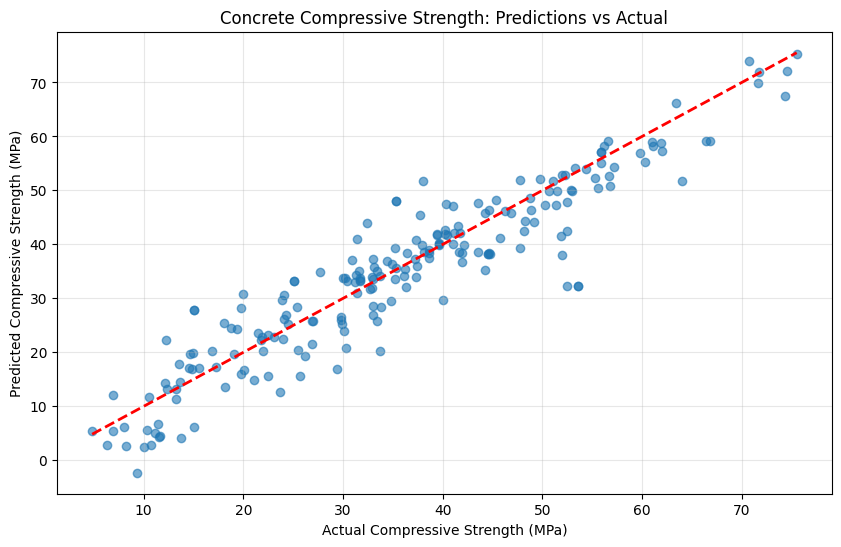


Top features influencing concrete strength:
- Cement content typically shows high importance
- Age of concrete is usually a strong predictor
- Water-to-cement ratio affects strength significantly


In [27]:
# Evaluate on test set
test_predictions = model.predict(X_test)
test_performance = model.evaluate(X_test, y_test)

print("Test Set Performance:")
for metric, value in test_performance.items():
    print(f"{metric}: {value:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Compressive Strength (MPa)')
plt.ylabel('Predicted Compressive Strength (MPa)')
plt.title('Concrete Compressive Strength: Predictions vs Actual')
plt.grid(True, alpha=0.3)
plt.show()

# Feature importance analysis
print("\nTop features influencing concrete strength:")
print("- Cement content typically shows high importance")
print("- Age of concrete is usually a strong predictor")
print("- Water-to-cement ratio affects strength significantly")